In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -q --pre pytorch-ignite

#fastai
!pip install -q fastai

#autogluon
#!pip install --upgrade -q mxnet==1.9.1
#!pip install -q autogluon==1.1.0

#transformers
#!pip install -q transformers==4.23.0
!pip install -q transformers[sentencepiece]
from torch.utils.data import ConcatDataset

#exit()

In [3]:
!git clone https://github.com/ccs3312/chml.git

Cloning into 'chml'...
remote: Enumerating objects: 1278, done.
remote: Counting objects: 100% (714/714), done.
remote: Compressing objects: 100% (708/708), done.
remote: Total 1278 (delta 5), reused 713 (delta 4), pack-reused 564
Receiving objects: 100% (1278/1278), 135.12 MiB | 53.46 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [4]:
from fastai.vision.all import *

In [5]:
class RandomHue(Transform):
    def __init__(self, max_hue:float=0.2):  # max_hue is a float between 0 and 0.5
        self.max_hue = max_hue
    
    def encodes(self, img: PILImage):
        # Convert to HSV to change hue
        hsv_img = img.convert('HSV')
        h, s, v = hsv_img.split()
        
        # Apply random hue shift
        hue_shift = random.uniform(-self.max_hue, self.max_hue)
        h = h.point(lambda x: (x + int(hue_shift * 255)) % 255)
        
        # Reconstruct and return the new image
        hsv_img = Image.merge('HSV', (h, s, v))
        return PILImage(hsv_img.convert('RGB'))
dblock = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter = GrandparentSplitter(train_name='ts', valid_name='vs'),
    get_y = parent_label,
    item_tfms=Resize(448),
    batch_tfms=[*aug_transforms(size=(448, 448))]
)
dls = dblock.dataloaders('chml/ColHamMLSwap/', bs = 64)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 98.4MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,2.472158,2.780230,0.200000,00:10


epoch,train_loss,valid_loss,accuracy,time
0,1.611651,2.727612,0.240000,00:12
1,1.369609,3.225246,0.220000,00:12
2,1.162028,3.176226,0.260000,00:12
3,0.983551,3.708650,0.280000,00:12
4,0.839117,3.852587,0.280000,00:12
5,0.736475,3.906411,0.260000,00:13


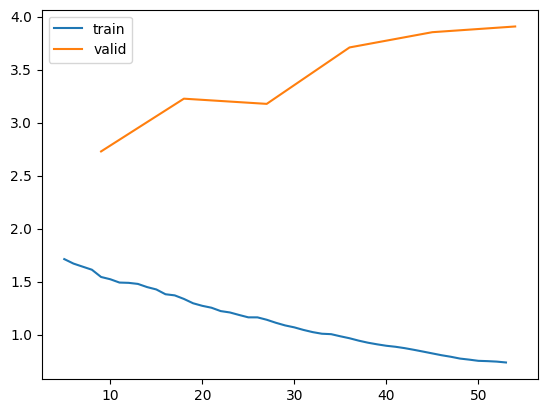

In [6]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(epochs=6, freeze_epochs=1, base_lr=2e-3)
learn.recorder.plot_loss()

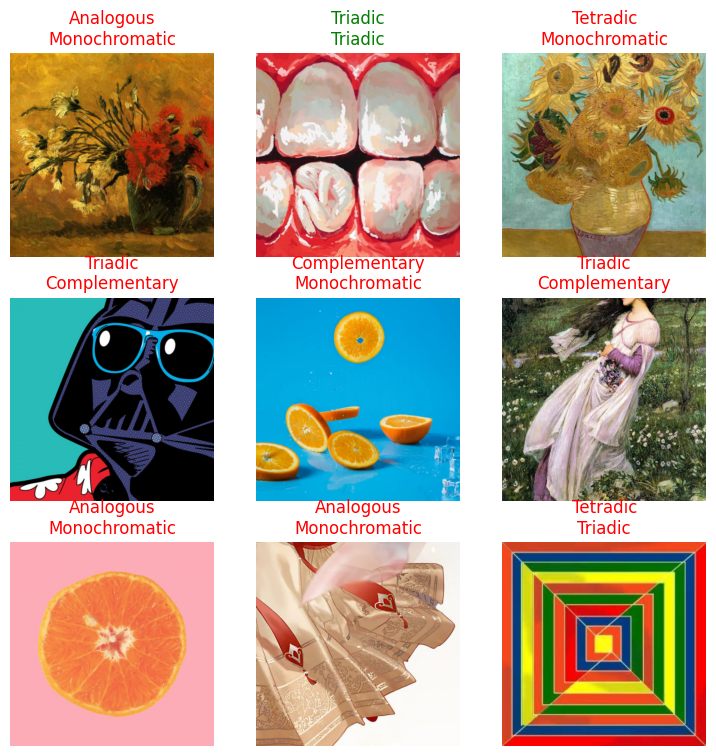

In [7]:
learn.show_results()

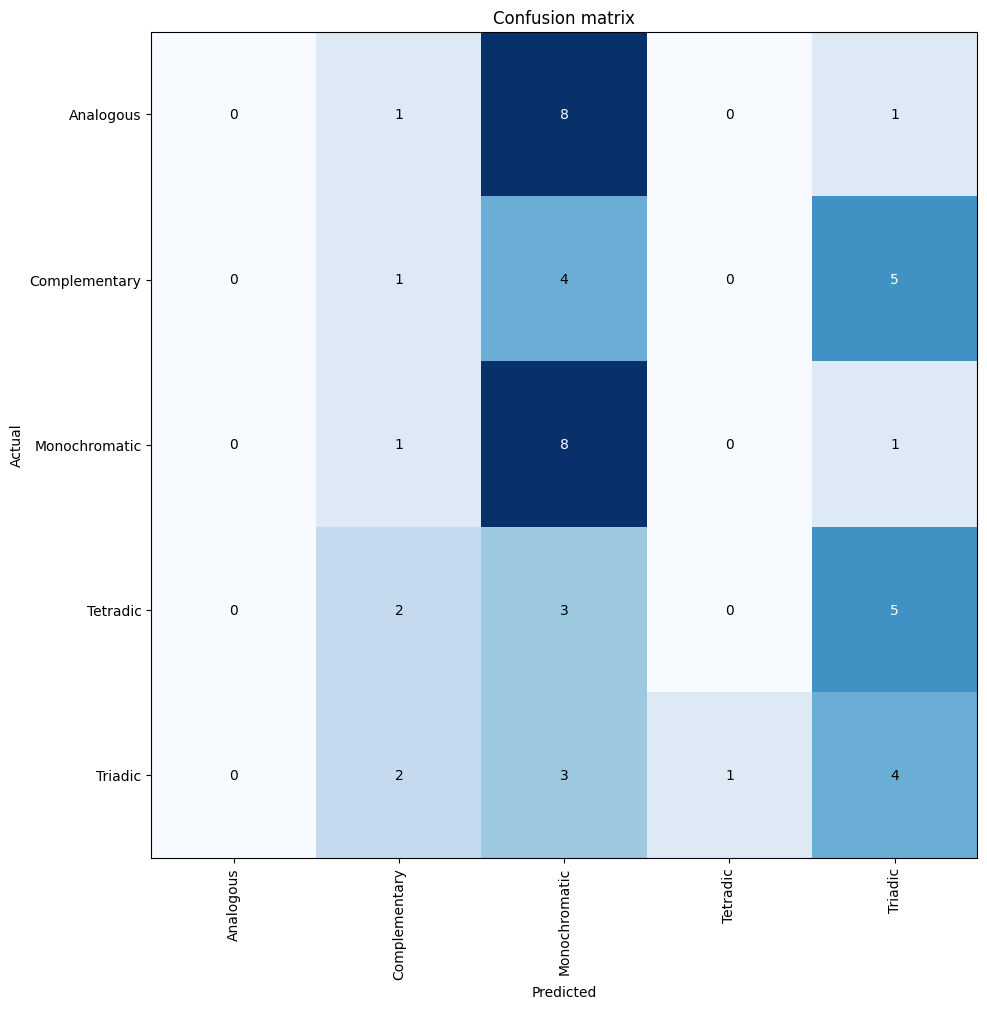

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))